# EE 344 Data-Driven Modeling And Machine Learning (Winter 2026)
## Case Study 3: Predicting Medical Charges

Goal: build and compare regression models that predict **medical insurance charges** from patient attributes.

Workflow:
- Load and review the dataset
- Split into train/test sets
- One-hot encode categorical features
- Train and evaluate Elastic Net, KNN, Decision Tree, and Random Forest models

Metrics reported on both train and test sets: **RMSE**, **MAE**, and **R²**.


In [1]:
# Imports (run this cell first)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, r2_score
try:
    # sklearn >= 1.4
    from sklearn.metrics import root_mean_squared_error
    def rmse(y_true, y_pred):
        return root_mean_squared_error(y_true, y_pred)
except Exception:
    # fallback
    from sklearn.metrics import mean_squared_error
    def rmse(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)

RANDOM_STATE = 50
np.random.seed(RANDOM_STATE)


In [2]:
# Helper: evaluate a trained model on train/test

def evaluate_regression(model, X_train, X_test, y_train, y_test):
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)

    results = {
        "RMSE_train": rmse(y_train, pred_train),
        "RMSE_test":  rmse(y_test, pred_test),
        "MAE_train":  mean_absolute_error(y_train, pred_train),
        "MAE_test":   mean_absolute_error(y_test, pred_test),
        "R2_train":   r2_score(y_train, pred_train),
        "R2_test":    r2_score(y_test, pred_test),
    }
    return results


## Load the dataset

Load the provided CSV file and run basic checks: shape, data types, and missing values.

In [3]:
# Load dataset

import os

csv_path = "medical-charges.csv"
df = pd.read_csv(csv_path)
df.head(10)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [4]:
# Quick sanity checks

print("Shape:", df.shape)
display(df.dtypes)
print("\nMissing values per column:")
display(df.isna().sum())

display(df.describe(include="all").T)


Shape: (1338, 7)


,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64



Missing values per column:


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


## Train/test split and preprocessing

Target: `charges`. Features: all remaining columns.

Preprocessing:
- Categorical features are one-hot encoded
- Scaling is applied only in pipelines where it is beneficial (distance-based models)


In [5]:
# Features (X) and target (y)

X = df.drop(columns=["charges"])
y = df["charges"]

num_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "smoker", "region"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (936, 6) Test: (402, 6)


In [6]:
# Preprocessing

# 1)  One-hot encode categoricals, pass numeric through unchanged
preprocess_ohe = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

# 2) Scale ALL features after OHE
preprocess_scaled = Pipeline(
    steps=[
        ("ohe", preprocess_ohe),
        ("scaler", StandardScaler()),
    ]
)

preprocess_unscaled = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)


## Elastic Net regression

Elastic Net is a regularized linear regression model that combines L1 (lasso) and L2 (ridge) penalties.


In [7]:
# Elastic Net pipeline + grid search

enet_pipe = Pipeline(steps=[
    ("prep", preprocess_scaled),
    ("model", ElasticNet(random_state=42, max_iter=20000)),
])

enet_param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

enet_search = GridSearchCV(
    enet_pipe,
    param_grid=enet_param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=1
)

enet_search.fit(X_train, y_train)

print("Best ElasticNet params:", enet_search.best_params_)
print("Best CV RMSE:", -enet_search.best_score_)

enet_best = enet_search.best_estimator_
enet_results = evaluate_regression(enet_best, X_train, X_test, y_train, y_test)
enet_results

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e+10, tolerance: 1.072e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+10, tolerance: 9.916e+06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+10, tolerance: 1.073e

Best ElasticNet params: {'model__alpha': 0.01, 'model__l1_ratio': 0.3}
Best CV RMSE: 6186.001665124919


{'RMSE_train': 6103.840910076836,
 'RMSE_test': 5970.696013615116,
 'MAE_train': 4180.749037225495,
 'MAE_test': 4093.4256754487483,
 'R2_train': 0.7314854384411096,
 'R2_test': 0.7826628678827265}

## K-Nearest Neighbors regression

KNN predicts charges using the average (optionally distance-weighted) of nearby observations.


In [8]:
# KNN pipeline + grid search

knn_pipe = Pipeline(steps=[
    ("prep", preprocess_scaled),
    ("model", KNeighborsRegressor()),
])

knn_param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15],
    "model__weights": ["uniform", "distance"],
}

knn_search = GridSearchCV(
    knn_pipe,
    param_grid=knn_param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=1
)

knn_search.fit(X_train, y_train)

print("Best KNN params:", knn_search.best_params_)
print("Best CV RMSE:", -knn_search.best_score_)

knn_best = knn_search.best_estimator_
knn_results = evaluate_regression(knn_best, X_train, X_test, y_train, y_test)
knn_results


Best KNN params: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Best CV RMSE: 5635.429522222771


{'RMSE_train': 442.405182721486,
 'RMSE_test': 5322.2341269107,
 'MAE_train': 20.450186805555557,
 'MAE_test': 3231.3826549393852,
 'R2_train': 0.9985894066140281,
 'R2_test': 0.8273081023505297}

## Decision Tree regression

A decision tree learns a sequence of split rules to predict charges.
Depth and leaf-size constraints are tuned to control overfitting.


In [9]:
# Decision Tree pipeline + grid search

dt_pipe = Pipeline(steps=[
    ("prep", preprocess_unscaled),
    ("model", DecisionTreeRegressor(random_state=RANDOM_STATE)),
])

dt_param_grid = {
    "model__max_depth": [2, 3, 4, 5, 6, 8, 10, None],
    "model__min_samples_leaf": [1, 2, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
}

dt_search = GridSearchCV(
    dt_pipe,
    param_grid=dt_param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=1
)

dt_search.fit(X_train, y_train)

print("Best DT params:", dt_search.best_params_)
print("Best CV RMSE:", -dt_search.best_score_)

dt_best = dt_search.best_estimator_
dt_results = evaluate_regression(dt_best, X_train, X_test, y_train, y_test)
dt_results


Best DT params: {'model__max_depth': 4, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Best CV RMSE: 4576.553817288269


{'RMSE_train': 4432.459278868424,
 'RMSE_test': 4488.242252825828,
 'MAE_train': 2539.1290369657154,
 'MAE_test': 2636.3572831526076,
 'R2_train': 0.8584040146803052,
 'R2_test': 0.8771891913825957}

### Decision Tree interpretation
Feature importance and a compact visualization help summarize the fitted tree.

,feature,importance
5,cat__smoker_no,0.703751
1,num__bmi,0.173735
0,num__age,0.118511
2,num__children,0.003409
7,cat__region_northeast,0.000594
4,cat__sex_male,0.000000
3,cat__sex_female,0.000000
6,cat__smoker_yes,0.000000
8,cat__region_northwest,0.000000
9,cat__region_southeast,0.000000


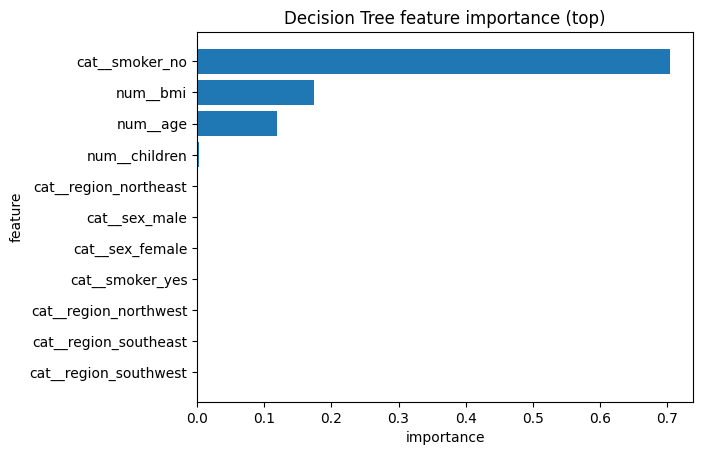

In [10]:
# Feature importance (Decision Tree)

dt_model = dt_best.named_steps["model"]
dt_prep  = dt_best.named_steps["prep"]

feature_names = dt_prep.get_feature_names_out()
importances = dt_model.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

display(fi)

# Plot top features
top_k = min(12, len(fi))
plt.figure()
plt.barh(fi["feature"].head(top_k)[::-1], fi["importance"].head(top_k)[::-1])
plt.title("Decision Tree feature importance (top)")
plt.xlabel("importance")
plt.ylabel("feature")
plt.show()


### Decision Tree diagram

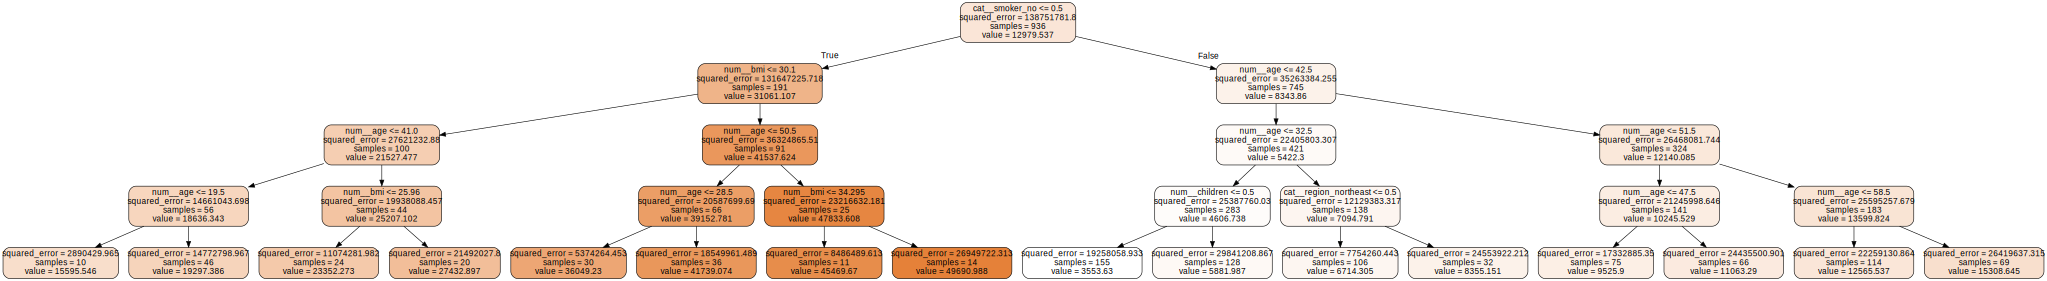

In [18]:
# Note: The following visualization requires Graphviz to be available in the runtime environment.

from sklearn.tree import export_graphviz
import graphviz

prep = dt_best.named_steps["prep"]
dt_model = dt_best.named_steps["model"]
feature_names = prep.get_feature_names_out()

dot = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=5
)
graphviz.Source(dot)


## Random Forest regression

A random forest aggregates many decision trees trained on bootstrapped samples with feature subsampling.
Key hyperparameters are tuned using cross-validation.


In [19]:
# Random Forest pipeline + randomized search

rf_pipe = Pipeline(steps=[
    ("prep", preprocess_unscaled),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1)),
])

rf_param_dist = {
    "model__n_estimators": [10, 50, 100],
    "model__max_depth": [None, 4, 5, 6],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__max_features": ["sqrt", 0.8, 1],
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=8,
    cv=3,
    random_state=RANDOM_STATE,
    scoring="neg_root_mean_squared_error",
    n_jobs=1
)

rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
print("Best CV RMSE:", -rf_search.best_score_)

rf_best = rf_search.best_estimator_
rf_results = evaluate_regression(rf_best, X_train, X_test, y_train, y_test)
rf_results


Best RF params: {'model__n_estimators': 10, 'model__min_samples_leaf': 5, 'model__max_features': 0.8, 'model__max_depth': 4}
Best CV RMSE: 4661.150305235016


{'RMSE_train': 4319.066042109803,
 'RMSE_test': 4356.483910005391,
 'MAE_train': 2465.666791542858,
 'MAE_test': 2529.268404502028,
 'R2_train': 0.8655560942417162,
 'R2_test': 0.8842939041769725}

### Random Forest feature importance

Feature importance provides a compact view of which encoded features contribute most to the fitted forest.


,feature,importance
5,cat__smoker_no,0.524739
1,num__bmi,0.178144
6,cat__smoker_yes,0.170052
0,num__age,0.116333
2,num__children,0.007496
9,cat__region_southeast,0.001115
7,cat__region_northeast,0.000927
4,cat__sex_male,0.000819
8,cat__region_northwest,0.000210
10,cat__region_southwest,0.000107


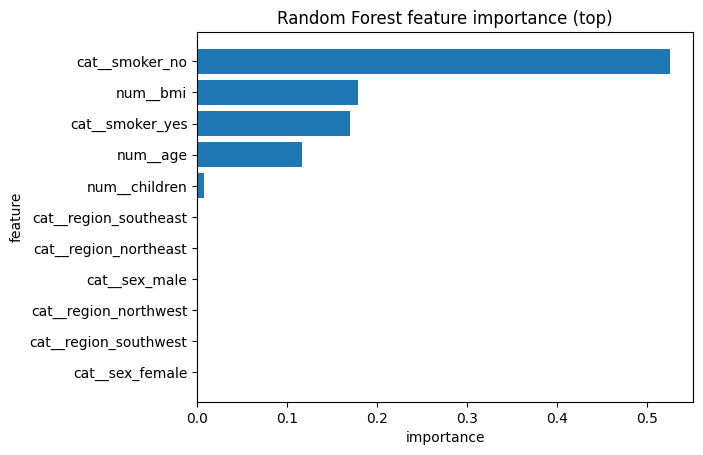

In [21]:
# Feature importance (Random Forest)

rf_model = rf_best.named_steps["model"]
rf_prep  = rf_best.named_steps["prep"]

feature_names = rf_prep.get_feature_names_out()
importances = rf_model.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

display(fi)

# Plot top features
top_k = min(12, len(fi))
plt.figure()
plt.barh(fi["feature"].head(top_k)[::-1], fi["importance"].head(top_k)[::-1])
plt.title("Random Forest feature importance (top)")
plt.xlabel("importance")
plt.ylabel("feature")
plt.show()


## Model comparison

Results are summarized side-by-side for train and test sets.


In [22]:
# Collect results

results_table = pd.DataFrame({
    "ElasticNet": enet_results,
    "KNN": knn_results,
    "DecisionTree": dt_results,
    "RandomForest": rf_results
}).T

# A cleaner view (rounded)
display(results_table.round(3))

# Sort by test RMSE
display(results_table.sort_values("RMSE_test").round(3))


,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
ElasticNet,6103.841,5970.696,4180.749,4093.426,0.731,0.783
KNN,442.405,5322.234,20.450,3231.383,0.999,0.827
DecisionTree,4432.459,4488.242,2539.129,2636.357,0.858,0.877
RandomForest,4319.066,4356.484,2465.667,2529.268,0.866,0.884


,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
RandomForest,4319.066,4356.484,2465.667,2529.268,0.866,0.884
DecisionTree,4432.459,4488.242,2539.129,2636.357,0.858,0.877
KNN,442.405,5322.234,20.450,3231.383,0.999,0.827
ElasticNet,6103.841,5970.696,4180.749,4093.426,0.731,0.783


In [23]:
# Actual vs Predicted (Random Forest) — quick table
y_pred = rf_best.predict(X_test)  # rf_best is your fitted best RF pipeline

pd.DataFrame({
    "actual": y_test.to_numpy(),
    "predicted": y_pred
}).head(20)


,actual,predicted
0,5976.83110,6730.243481
1,5846.91760,6599.540173
2,13831.11520,12803.316785
3,9625.92000,12232.084183
4,2680.94930,4754.514877
5,47896.79135,47238.197583
6,18223.45120,18571.735065
7,7419.47790,8040.264790
8,3732.62510,4974.751161
9,12222.89830,13788.230555


## Summary

- Elastic Net provides a regularized linear baseline.
- KNN can perform well when local neighborhoods are informative, but it is sensitive to scaling and the choice of K.
- Decision Trees capture non-linear structure but can overfit without depth and leaf constraints.
- Random Forests typically improve generalization by averaging many trees.
